In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate

In [2]:
class Kepler(object):
    """Class to calculate the Kepler problem
    
    Parameters
    ----------
    
    mass : np.float32
        total mass

    diff : np.float32
        amount for finite difference derivative for potential
    
    Notes
    -----
    
    Calculates derivative from potential instead of force law directly
    (more easily accommodates perturbations to potential)
    
    Set up to use RK4/5 by default
"""
    def __init__(self, mass=1., diff=1.e-7):
        self.mass = mass
        self.diff = diff
        self.xdiff = np.array([self.diff, 0., 0.])
        self.ydiff = np.array([0., self.diff, 0.])
        self.zdiff = np.array([0., 0., self.diff])
        self.set_ode()
        return 
    def set_ode(self):
        """Setup ODE integrator (RK3)"""
        self.ode = scipy.integrate.ode(self.dwdt)
        self.ode.set_integrator('dopri5') # Runge-Kutta
        return
    def _diff_central(self, func=None, x=None, dx=None, factor=1.):
        """Central difference"""
        return((func(x + 0.5 * dx * factor) - func(x - 0.5 * dx * factor)) /
               (factor * self.diff))
    def _diff_correct(self, func=None, x=None, dx=None):
        """Higher order difference"""
        return((4. * self._diff_central(func=func, x=x, dx=dx, factor=0.5) -
                self._diff_central(func=func, x=x, dx=dx)) / 3.)
    def gradient(self, x=None):
        """Returns gradient
        
        Parameters
        ----------
        
        x : ndarray of np.float32
            [3]-d position
        
        Returns
        -------
        
        grad : ndarray of np.float32
            [3]-d gradient of potential
"""
        g = np.zeros(3)
        g[0] = self._diff_correct(func=self.potential, x=x, dx=self.xdiff)
        g[1] = self._diff_correct(func=self.potential, x=x, dx=self.ydiff)
        g[2] = self._diff_correct(func=self.potential, x=x, dx=self.zdiff)
        return g
    def potential(self, x=None):
        """Returns potential
        
        Parameters
        ----------
        
        x : ndarray of np.float32
            [3]-d position
        
        Returns
        -------
        
        phi : np.float32
            potential
"""
        r = np.sqrt(x[..., 0]**2 + x[..., 1]**2 + x[..., 2]**2)
        return - self.mass / r
    def dwdt(self, t, w):
        """Phase space time derivative
        
        Parameters
        ----------
        
        t : np.float32
            current time
            
        w : ndarray of np.float32
            [6] phase space coords (3 position then 3 velocity)
        
        Returns
        -------
        
        dwdt : ndarray of np.float32
            [6] time derivatives to integrate
"""
        x = w[:3]
        v = w[3:]
        dwdt = np.zeros(6)
        dwdt[:3] = v
        dwdt[3:] = - self.gradient(x)
        return(dwdt)
    def energy(self, w=None):
        """Calculate energy of position
        
        Parameters
        ----------
        
        w : ndarray of np.float32
            [..., 3] phase space coords
            
        Returns
        -------
        
        energy : ndarray of np.float32
            energy
"""
        pe = self.potential(w[..., :3])
        ke = 0.5 * (w[..., 3:]**2).sum(axis=-1)
        return(pe + ke)
    def integrate(self, w0=None, t0=0., dt=0.1, nt=100):
        """Integrate the equations
        
        Parameters
        ----------
        
        t0 : np.float32
            initial time
            
        w0 : ndarray of np.float32
            [6] initial phase space coords (3 position then 3 velocity)
            
        dt : np.float32
            time interval to integrate per output
            
        nt : np.int32
            number of intervals
"""
        self.ode.set_initial_value(w0, t0)
        w = np.zeros((nt, 6))
        t = np.zeros(nt)
        w[0, :] = w0
        t[0]= t0
        for indx in np.arange(nt - 1) + 1:
            t[indx] = t[indx - 1] + dt
            self.ode.integrate(self.ode.t + dt)
            w[indx, :] = self.ode.y
        return(t, w)

# Simple circular orbits

In [3]:
kepler = Kepler()

In [4]:
w0 = np.array([1., 0., 0., 0., 1.0, 0.])
(t, w) = kepler.integrate(w0=w0, nt=500)
error1 = w[:, 0] - np.cos(t)

<IPython.core.display.Javascript object>


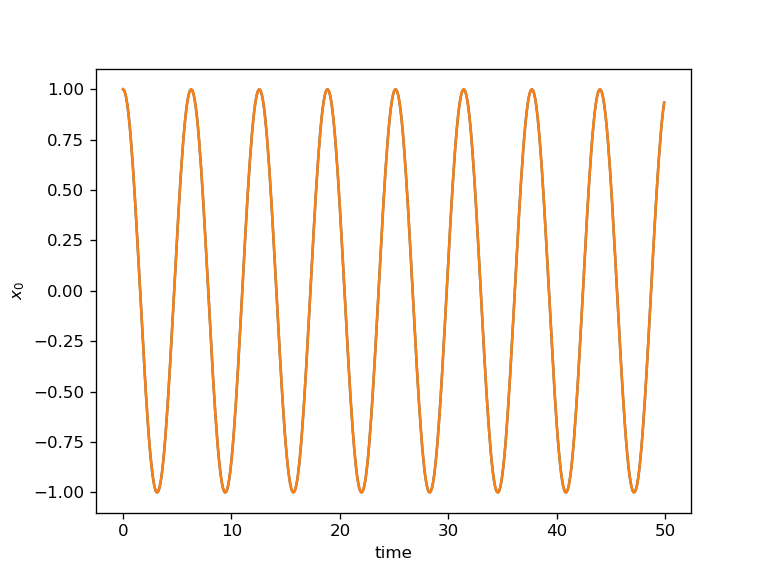

Text(0, 0.5, '$x_0$')

In [5]:
plt.plot(t, w[:, 0])
plt.plot(t, np.cos(t))
plt.xlabel('time')
plt.ylabel('$x_0$')

<IPython.core.display.Javascript object>


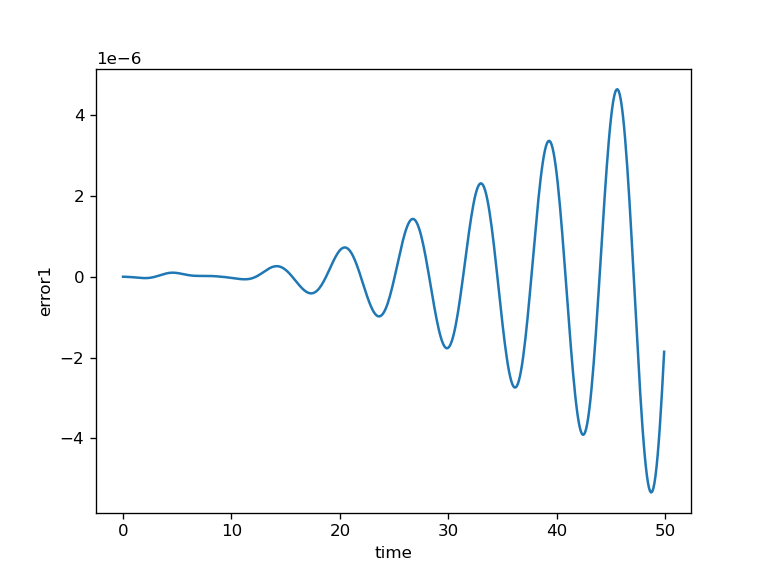

Text(0, 0.5, 'error1')

In [6]:
plt.plot(t, error1)
plt.xlabel('time')
plt.ylabel('error1')

<IPython.core.display.Javascript object>


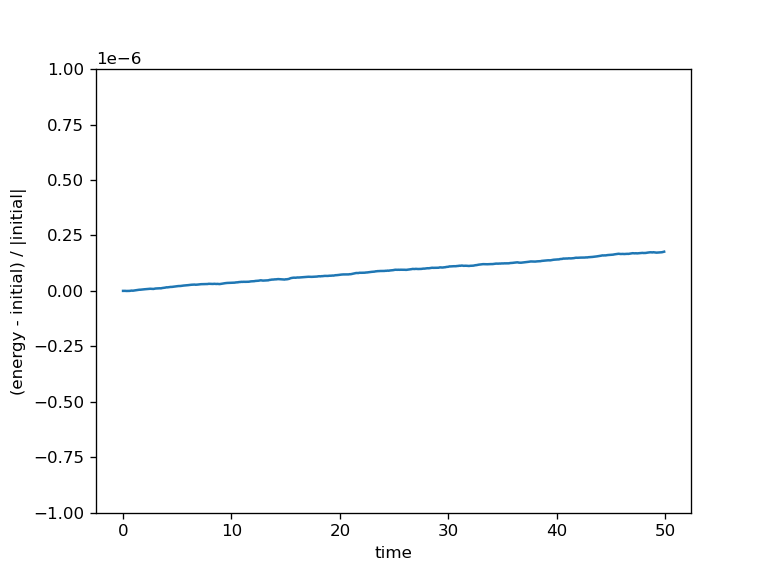

(-1e-06, 1e-06)

In [7]:
energy = kepler.energy(w)
plt.plot(t, (energy + 0.5) / 0.5)
plt.xlabel('time')
plt.ylabel('(energy - initial) / |initial|')
plt.ylim([-1.e-6, 1.e-6])

<IPython.core.display.Javascript object>


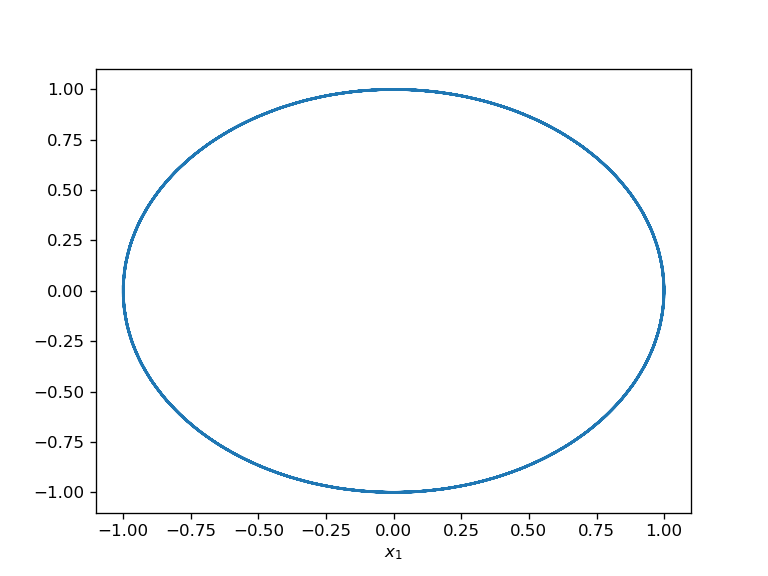

Text(0.5, 0, '$x_1$')

In [8]:
plt.plot(w[:, 0], w[:, 1])
plt.xlabel('$x_0$')
plt.xlabel('$x_1$')

# Simple Circular Orbit (RK2)

In [9]:
class RK2ODE(object):
    """RK2 ODE object
    
    Parameters
    ----------
    
    dt : np.float32
        time step
        
    dydt : function
        function taking t, y to return y derivs
    
    Attributes
    ----------
    
    y : ndarray of np.float32
        current position 
        
    t : np.float32
        current time

    dt : np.float32
        time step
        
    dydt : function
        function taking t, y to return y derivs
"""
    def __init__(self, dt=1.e-5, dydt=None):
        self.y = None
        self.t = None
        self.dt = dt
        self.dydt = dydt
        return
    def set_initial_value(self, y0=None, t0=None):
        """Set initial values
        
        Parameters
        ----------
        
        t0 : np.float32
            initial time 
        
        y0 : ndarray of np.float32
            initial position 
"""
        self.y = y0
        self.t = t0
        return
    def integrate(self, tend=None):
        """Integrate to a time
        
        Parameters
        ----------
        
        tend : np.float32
            time to integrate to
            
        Notes
        -----
        
        Assumes you are taking many steps. Does first step as Euler,
        and just extends last step to reach desired time.
"""
        y = self.y.copy()
        t = self.t
        while t < tend:
            dydt = self.dydt(t, y)
            y05 = y + 0.5 * dydt * self.dt
            t05 = t + self.dt * 0.5
            dydt05 = self.dydt(t05, y05)
            y = y + dydt05 * self.dt
            t = t + self.dt
        dydt = self.dydt(t, y)
        dt = tend - t
        y = y + dydt * dt
        self.y = y
        self.t = tend    
        return
        
class KeplerRK2(Kepler):
    """Kepler problem with the RK2 integrator"""
    def set_ode(self, dt=1.e-3):
        """Setup ODE integrator (RK3)"""
        self.ode = RK2ODE(dt=dt, dydt=self.dwdt)
        return

Let's try one choice of time step.

In [10]:
kepler = KeplerRK2()
kepler.set_ode(dt=1.e-3)

In [11]:
w0 = np.array([1., 0., 0., 0., 1.0, 0.])
(t, w) = kepler.integrate(w0=w0, nt=500)
error1 = w[:, 0] - np.cos(t)

<IPython.core.display.Javascript object>


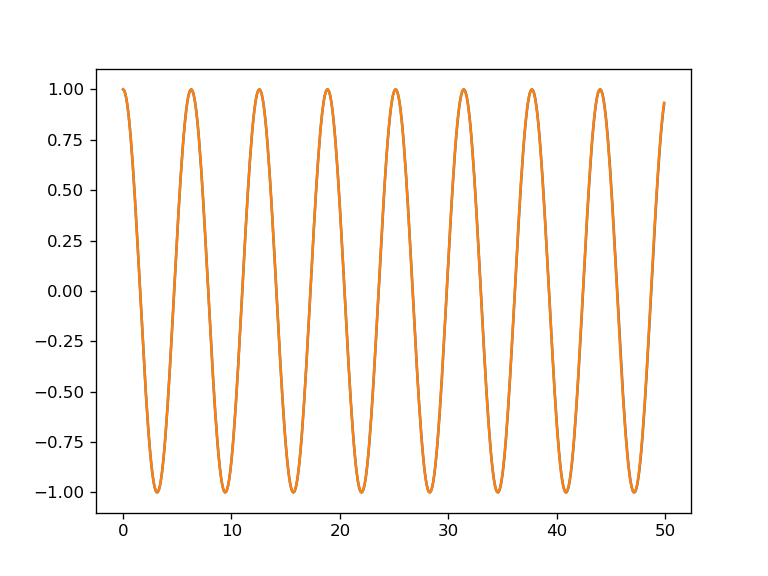

In [12]:
plt.plot(t, w[:, 0])
plt.plot(t, np.cos(t))

<IPython.core.display.Javascript object>


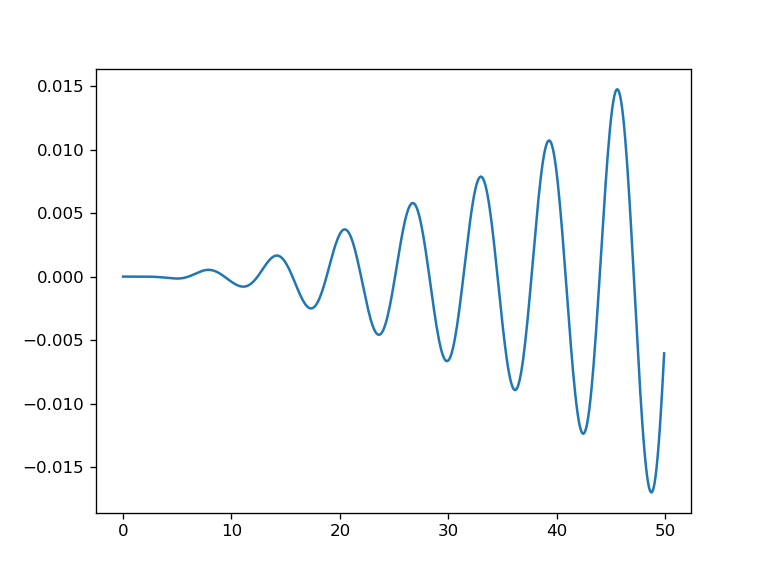

In [13]:
plt.plot(t, w[:, 0] - np.cos(t))

<IPython.core.display.Javascript object>


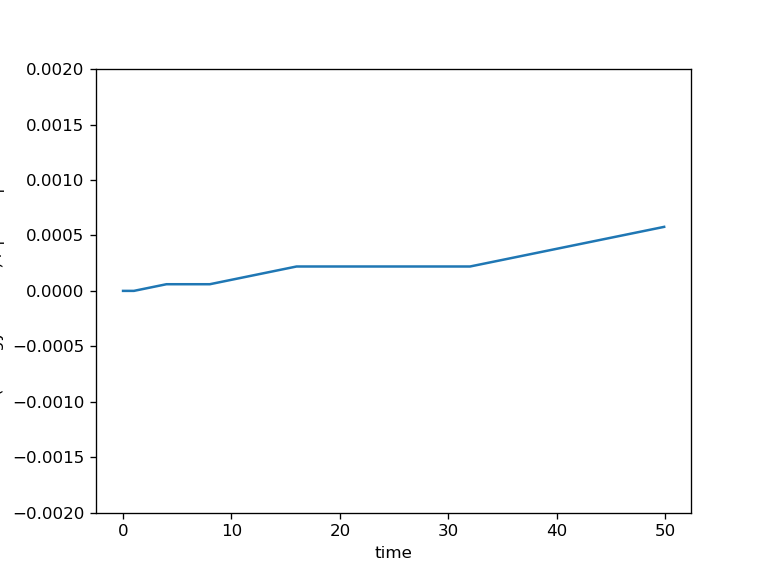

(-0.002, 0.002)

In [14]:
energy = kepler.energy(w)
plt.plot(t, (energy + 0.5) / 0.5)
plt.xlabel('time')
plt.ylabel('(energy - initial) / |initial|')
plt.ylim([-2.e-3, 2.e-3])

Now check that a time step 10 times finer gets an (integrated) error 100 times better.

In [15]:
kepler = KeplerRK2()
kepler.set_ode(dt=1.e-4)

In [16]:
w0 = np.array([1., 0., 0., 0., 1.0, 0.])
(t, w) = kepler.integrate(w0=w0, nt=500)
error1 = w[:, 0] - np.cos(t)

<IPython.core.display.Javascript object>


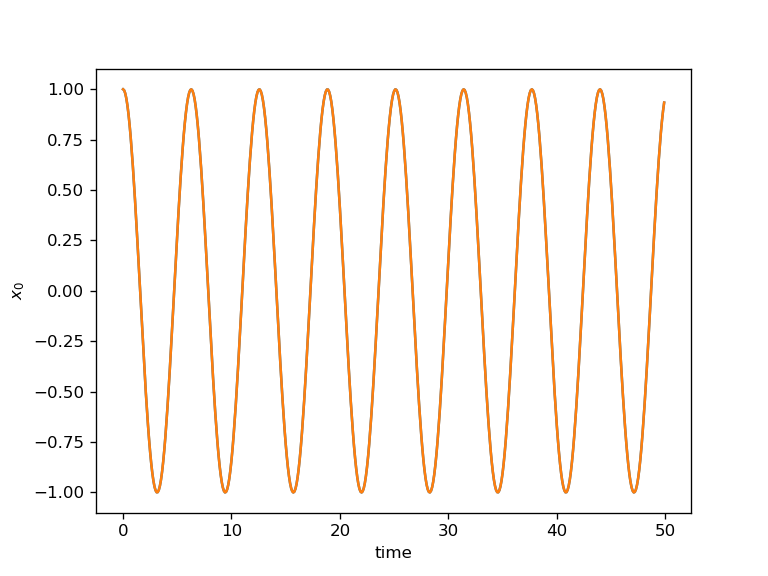

Text(0, 0.5, '$x_0$')

In [19]:
plt.plot(t, w[:, 0])
plt.plot(t, np.cos(t))
plt.xlabel('time')
plt.ylabel('$x_0$')

<IPython.core.display.Javascript object>


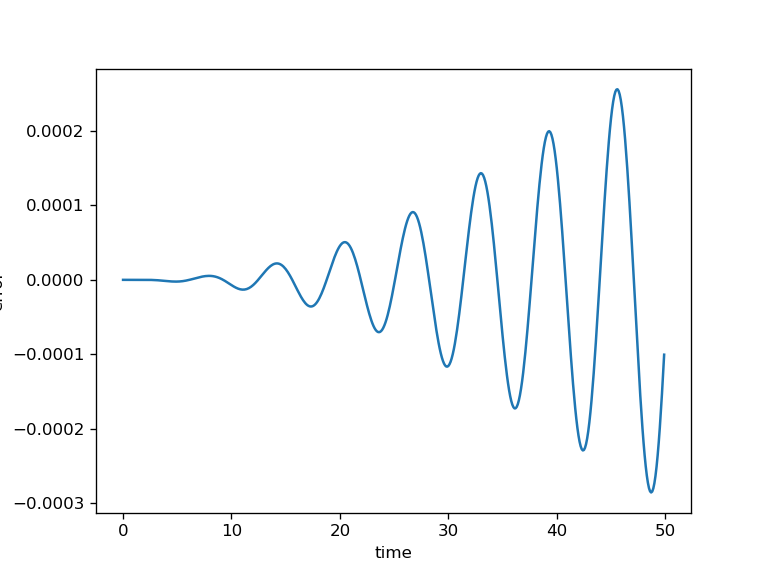

Text(0, 0.5, 'error')

In [20]:
plt.plot(t, w[:, 0] - np.cos(t))
plt.xlabel('time')
plt.ylabel('error')

# Simple Circular Orbit (with Verlet)

In [21]:
class VerletODE(object):
    """Verlet ODE object
    
    Parameters
    ----------
    
    dt : np.float32
        time step
        
    dydt : function
        function taking t, y to return y derivs
    
    Attributes
    ----------
    
    y : ndarray of np.float32
        current position 
        
    t : np.float32
        current time

    dt : np.float32
        time step
        
    dydt : function
        function taking t, y to return y derivs
"""
    def __init__(self, dt=1.e-5, dydt=None):
        self.y = None
        self.t = None
        self.dt = dt
        self.dydt = dydt
        return
    
    def set_initial_value(self, y0=None, t0=None):
        """Set initial values
        
        Parameters
        ----------
        
        t0 : np.float32
            initial time 
        
        y0 : ndarray of np.float32
            initial position 
"""
        self.y = y0
        self.t = t0
        return
    
    def integrate(self, tend=None):
        """Integrate to a time
        
        Parameters
        ----------
        
        tend : np.float32
            time to integrate to
            
        Notes
        -----
        
        Assumes you are taking many steps. 
        Just extends last step to reach desired time.
"""
        x = self.y[:3]
        v = self.y[3:]
        tv = self.t
        x = x + 0.5 * v * self.dt
        tx = self.t + 0.5 * self.dt
        y = np.zeros(6, dtype=np.float32)
        while tx < tend: 
            y[:3] = x
            y[3:] = v
            dydt = self.dydt(t, y)
            v = v + dydt[3:] * self.dt
            tv = tv + self.dt
            x = x + v * self.dt
            tx = tx + self.dt
        x = x + v * (tend - tx)
        y[:3] = x
        dydt = self.dydt(tend, y)
        v = v + dydt[3:] * (tend - tv)
        y[3:] = v
        self.y = y
        self.t = tend    
        return
        
class KeplerVerlet(Kepler):
    def set_ode(self, dt=1.e-3):
        """Setup ODE integrator (RK3)"""
        self.ode = VerletODE(dt=dt, dydt=self.dwdt)
        return

In [22]:
kepler = KeplerVerlet()
kepler.set_ode(dt=1.e-3)

In [23]:
w0 = np.array([1., 0., 0., 0., 1.0, 0.])
(t, w) = kepler.integrate(w0=w0, nt=500, dt=0.1)

<IPython.core.display.Javascript object>


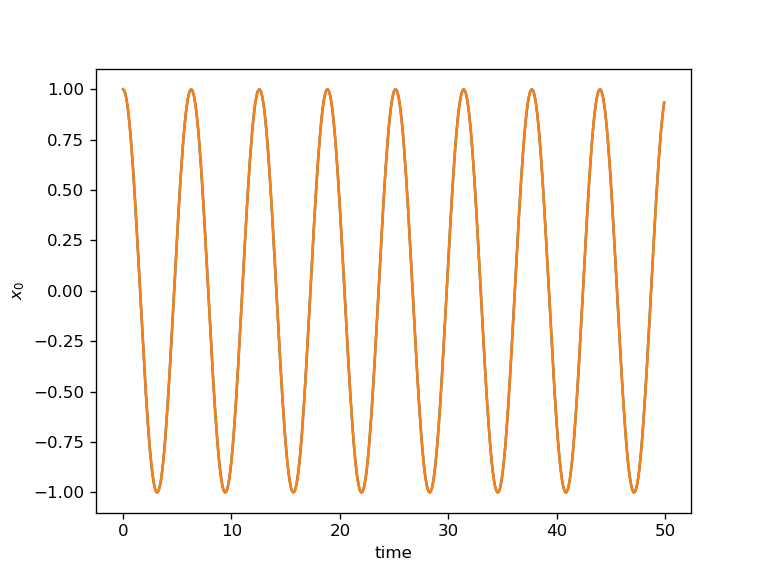

Text(0, 0.5, '$x_0$')

In [24]:
plt.plot(t, w[:, 0])
plt.plot(t, np.cos(t))
plt.xlabel('time')
plt.ylabel('$x_0$')

<IPython.core.display.Javascript object>


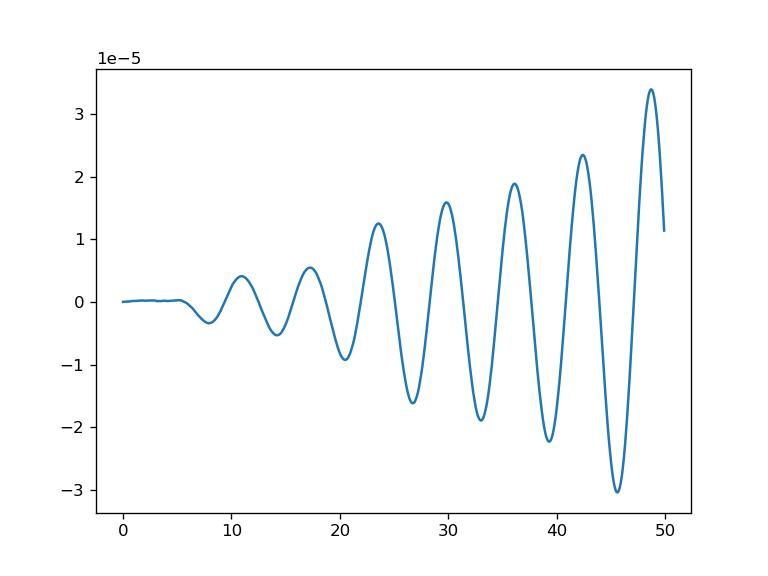

In [25]:
plt.plot(t, w[:, 0] - np.cos(t))

In [26]:
energy = kepler.energy(w)
plt.plot(t, (energy + 0.5) / 0.5)
plt.xlabel('time')
plt.ylabel('(energy - initial) / |initial|')
plt.ylim([-2.e-5, 2.e-5])

<IPython.core.display.Javascript object>

(-2e-05, 2e-05)

In [ ]:
kepler = KeplerVerlet()
kepler.set_ode(dt=3.e-3)

In [ ]:
w0 = np.array([1., 0., 0., 0., 1.0, 0.])
(t, w) = kepler.integrate(w0=w0, nt=500, dt=0.1)

In [ ]:
plt.plot(t, w[:, 0])
plt.plot(t, np.cos(t))
plt.xlabel('time')
plt.ylabel('$x_0$')

In [ ]:
plt.plot(t, w[:, 0] - np.cos(t))

In [ ]:
energy = kepler.energy(w)
plt.plot(t, (energy + 0.5) / 0.5)
plt.xlabel('time')
plt.ylabel('(energy - initial) / |initial|')
plt.ylim([-2.e-5, 2.e-5])

In [ ]:
kepler = KeplerVerlet()
kepler.set_ode(dt=3.e-3)

In [ ]:
w0 = np.array([1., 0., 0., 0., 0.8, 0.])
(t, w) = kepler.integrate(w0=w0, nt=500, dt=0.1)

In [ ]:
plt.plot(t, w[:, 0])
plt.xlabel('time')
plt.ylabel('$x_0$')

In [ ]:
energy = kepler.energy(w)
plt.plot(t, (energy + 0.68) / 0.68)
plt.xlabel('time')
plt.ylabel('(energy - initial) / |initial|')
plt.ylim([-2.e-5, 2.e-5])

# More complicated potential

In [ ]:
class KeplerBulge(Kepler):
    def potential(self, x=None):
        r = np.sqrt(x[0]**2 + x[1]**2 + x[2]**2)
        r3 = r**3
        return (- self.mass * (1. / r + 0.03 / r3))

In [ ]:
bulge = KeplerBulge()

w0 = np.array([2., 0., 0., 0.5, 0.5, 0.])
(t, w) = bulge.integrate(w0=w0, nt=1000)

In [ ]:
plt.plot(w[:, 0], w[:, 1])
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')

In [ ]:
class KeplerAsymmetric(Kepler):
    def potential(self, x=None):
        r = np.sqrt(x[0]**2 + 0.5 * x[1]**2 + x[2]**2)
        return (- self.mass * 1. / r)

In [ ]:
asym = KeplerAsymmetric()

w0 = np.array([1., 0., 0., 0., 0.5, 0.1])
(t, w) = asym.integrate(w0=w0, nt=1000, dt=0.01)

In [ ]:
plt.plot(w[:, 0], w[:, 1])
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')

# Stiff equation example

In [ ]:
def dwdt(t, w):
    x, y, z = w
    xdot = -0.04 * x + 1.e4 * y * z
    ydot = 0.04 * x - 1.e4 * y * z - 3.e7 * y**2
    zdot = 3.e7 * y**2
    return np.array([xdot, ydot, zdot])

In [ ]:
def dwdt_jac(t, w):
    x, y, z = w
    jac = np.zeros((3, 3), dtype=np.float32)
    jac[0, :] = [-0.04, 1.e+4 * z, 1.e+4 * y]
    jac[1, :] = [0.04, - 1.e+4 * z - 6e+7 * y, - 1.e+4 * y]
    jac[2, :] = [0, 6.e+7 * y, 0.]
    return(jac)

In [ ]:
results = scipy.integrate.solve_ivp(dwdt, [0., 500.], [1., 0., 0.], method='DOP853')
print(results)

In [ ]:
plt.plot(results.t, results.y[0, :], label="X")
plt.plot(results.t, results.y[1, :] * 1.e+4, label="$10^4$ Y")
plt.plot(results.t, results.y[2, :], label="Z")
plt.xlabel('Time')
plt.legend()

Radau is a 5th order implicit RK-like method. It requires the Jacobian, but solve_ivp will try finite differences if it doesn't get a Jacobian explicitly.

In [ ]:
results = scipy.integrate.solve_ivp(dwdt, [0., 500.], [1., 0., 0.], jac=dwdt_jac, method='Radau')
print(results)

In [ ]:
results = scipy.integrate.solve_ivp(dwdt, [0., 500.], [1., 0., 0.], jac=None, method='Radau')
print(results)

In [ ]:
plt.plot(results.t, results.y[0, :], label="X")
plt.plot(results.t, results.y[1, :] * 1.e+4, label="$10^4$ Y")
plt.plot(results.t, results.y[2, :], label="Z")
plt.xlabel('Time')
plt.legend()